# Gaussian Mixture Models

Gaussian mixture models (GMM) are a generative model that assumes the data has been generated by a mix of various multivariate normal distributions. The algorithm aims to estimate the mean & covariance matrices of these distributions.

It generalizes the k-Means algorithm: it adds covariance among features so that clusters can be ellipsoids rather than spheres, while the centroids are represented by the means of each distribution. The GMM algorithm performs soft assignments because each point has a probability to be a member of any cluster. 

## The Expectation-Maximization Algorithm

Expectation-Maximization Algorithm

GMM uses the expectation-maximization algorithm to identify the components of the mixture of Gaussian distributions. The goal is to learn the probability distribution parameters from unlabeled data.

The algorithm proceeds iteratively as follows:
1. Initialization: Assume random centroids (e.g. from K-Means)
2. Repeat until convergence (changes in assignments drop below threshold):
    1. Expectation Step: Soft assignment - compute probabilities for each point from each distribution
    2. Maximization Step: Adjust normal-distribution parameters to make data points most likely

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import atleast_2d

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [3]:
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))
sns.set_style('white')

## Load Iris Data

In [4]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

## Create DataFrame

In [5]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


### Standardize Data

In [6]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [7]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

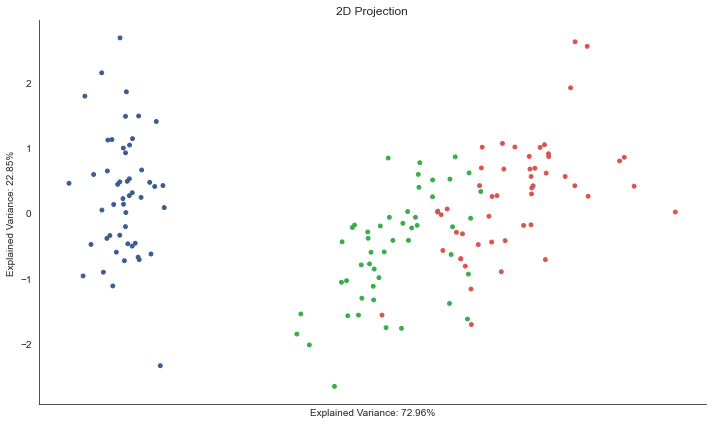

In [8]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(10, 6)).gca(title='2D Projection',
                                     xlabel=f'Explained Variance: {ev1:.2%}',
                                     ylabel=f'Explained Variance: {ev2:.2%}')
ax.scatter(*features_2D.T, c=data.label, s=15, cmap=cmap)
ax.set_xticklabels([])
ax.set_xticks([])
sns.despine()
plt.tight_layout();

## Perform GMM clustering

In [9]:
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(features_standardized)

GaussianMixture(n_components=3)

In [10]:
data['clusters'] = gmm.predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

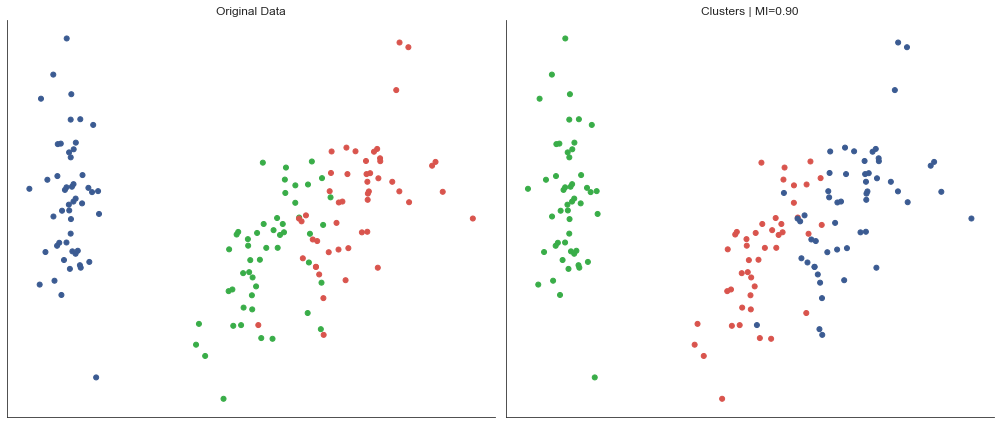

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

sns.despine()
fig.tight_layout()

### Visualize Gaussian Distributions

The following figures show the GMM cluster membership probabilities for the iris dataset as contour lines:

In [12]:
xmin, ymin = features_2D.min(axis=0)
xmax, ymax = features_2D.max(axis=0)

x = np.linspace(xmin, xmax, 500)
y = np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(x, y)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)

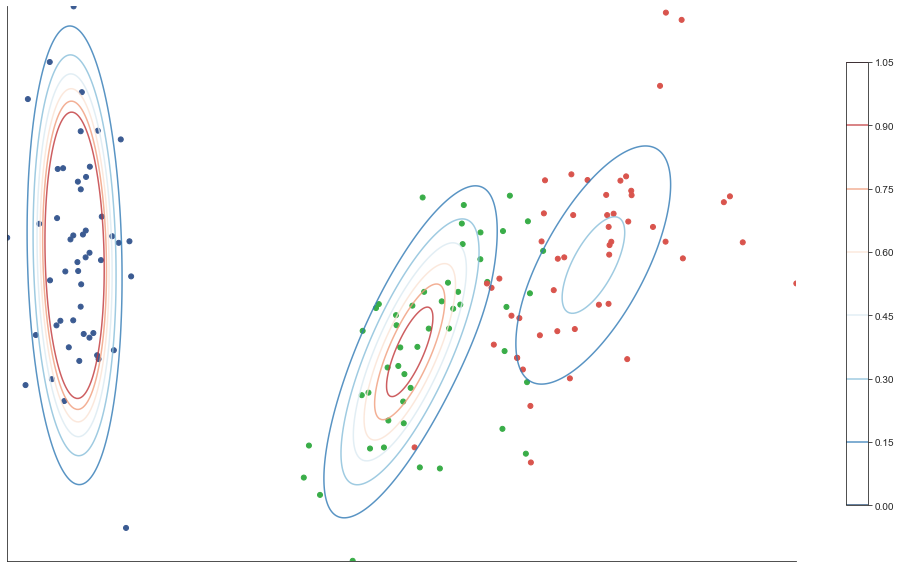

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

CS = ax.contour(X, Y, Z,
                cmap='RdBu_r',
                alpha=.8)
CB = plt.colorbar(CS, shrink=0.8)
ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

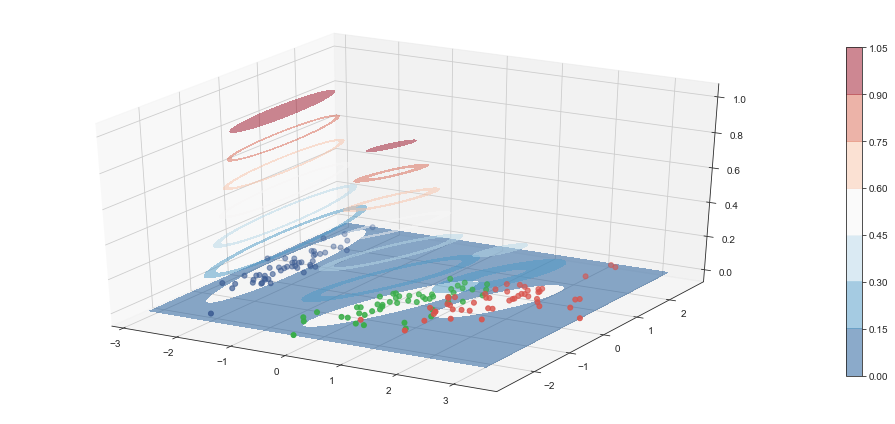

In [14]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca(projection='3d')

CS = ax.contourf3D(X, Y, Z, cmap='RdBu_r', alpha=.5)
CB = plt.colorbar(CS, shrink=0.8)

ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
fig.tight_layout()

### Bayesian Information Criterion 

We are looking for the minimum value, so two clusters would be the preferred solution; with three as the close runner-up (varies depending on random sample).

In [15]:
bic = {}
for n_components in range(2, 8):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(features_standardized)
    bic[n_components] = gmm.bic(features_standardized)
pd.Series(bic)

2    794.709002
3    801.550596
4    853.661060
5    901.537732
6    946.670985
7    936.832915
dtype: float64